In [13]:
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import numpy as np
import heapq


In [14]:
def build_frequency(pixel_array):
    return Counter(pixel_array)

class Node:
    def __init__(self, left=None, right=None, root=None):
        self.left = left
        self.right = right
        self.root = root

    def children(self):
        return (self.left, self.right)

    def __lt__(self, other):
        return self.root < other.root

In [15]:
def build_tree(frequencies):
    heap = [Node(root=freq, left=symbol) for symbol, freq in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        node = Node(left=left, right=right, root=left.root + right.root)
        heapq.heappush(heap, node)
    return heap[0]

In [16]:
def assign_codes(node, prefix="", code=None):
    if code is None:
        code = {}
    if isinstance(node.left, Node):
        assign_codes(node.left, prefix + "0", code)
    else:
        code[node.left] = prefix or "0"
    if isinstance(node.right, Node):
        assign_codes(node.right, prefix + "1", code)
    else:
        code[node.right] = prefix or "0"
    return code


In [17]:
def compute_stats(data):
    return [
        f"{min(data):.2f}",
        f"{max(data):.2f}",
        f"{statistics.mean(data):.2f}",
        f"{statistics.median(data):.2f}",
        f"{statistics.stdev(data):.2f}"
    ]

In [18]:
directory = "../asset"
original_sizes = []
encoded_sizes = []
compression_ratios = []

In [20]:
image_filenames = [filename for filename in os.listdir(directory) if filename.endswith(".jpg")]
print(f"Total images: {len(image_filenames)}")
increment = len(image_filenames) / 10
for idx, filename in enumerate(image_filenames):
    if idx % int(increment) == 0:
        percent = idx / len(image_filenames) * 100
        print(f"{percent:.0f}%")
    image_path = os.path.join(directory, filename)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        pixels = list(img.flatten())
        frequency = build_frequency(pixels)
        huffman_tree = build_tree(frequency)
        huffman_codes = assign_codes(huffman_tree)
        encoded_image = ''.join(huffman_codes[pixel] for pixel in pixels)

        original_size = len(pixels) * 8
        encoded_size = len(encoded_image)
        compression_ratio = original_size / encoded_size if encoded_size != 0 else 0

        original_sizes.append(original_size / 1024)
        encoded_sizes.append(encoded_size / 1024)
        compression_ratios.append(compression_ratio)


Total images: 757
0%
10%
20%
30%
40%
50%
59%
69%
79%
89%
99%


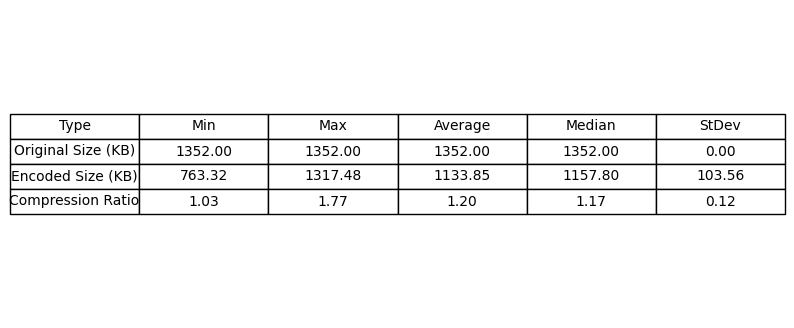

In [21]:
stats = {
    "Original Size (KB)": compute_stats(original_sizes),
    "Encoded Size (KB)": compute_stats(encoded_sizes),
    "Compression Ratio": compute_stats(compression_ratios)
}

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('tight')
ax.axis('off')
column_labels = ["Type", "Min", "Max", "Average", "Median", "StDev"]
table_data = [[key] + value for key, value in stats.items()]
table = ax.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
plt.show()